# PyHDX basics

In [10]:
from pyhdx import PeptideMasterTable, read_dynamx, HDXMeasurement
from pyhdx.plot import peptide_coverage
import matplotlib.pyplot as plt
import proplot as pplt
from pathlib import Path

We can use the ``read_dynamx`` function to read the input DynamX state file. Exposure times in the .csv files are in the
field exposure, and we specify the unit with the `time_unit` keyword argument. The exposure time units are converted to
seconds.

This function returns a ``numpy`` structured array where each entry corresponds to one peptide, in this example 567 peptides.

In [3]:
fpath = Path() / '..' / '..' / 'tests' / 'test_data' / 'input' / 'ecSecB_apo.csv'
data = read_dynamx(fpath, time_unit='min')
data.size

9072

This array is loaded into the ``PeptideMasterTable`` class, which is the main data entry class. The parameter ``drop_first``
determines how many N-terminal residues are considered to be fully back-exchanged, and therefore is subtracted from the
total amount of exchangable D per peptide. The parameter ``ignore_prolines`` is controls whether the number of Prolines
residues in the peptide should be subtracted from the total amount of exchangable and should generally be set to ``True``.

The final number of exchangable residues is found in the 'ex_residues' field.

In [4]:
master_table = PeptideMasterTable(data, drop_first=1, ignore_prolines=True)
master_table.data['ex_residues'][:50]

0      8.0
2      8.0
1      8.0
3      8.0
4      8.0
5      8.0
6      8.0
7      8.0
8      8.0
9      6.0
11     6.0
10     6.0
12     6.0
13     6.0
14     6.0
15     6.0
16     6.0
17     6.0
18    12.0
20    12.0
19    12.0
21    12.0
22    12.0
23    12.0
24    12.0
25    12.0
26    12.0
27    13.0
29    13.0
28    13.0
30    13.0
31    13.0
32    13.0
33    13.0
34    13.0
35    13.0
36    14.0
38    14.0
37    14.0
39    14.0
40    14.0
41    14.0
42    14.0
43    14.0
44    14.0
45    20.0
47    20.0
46    20.0
48    20.0
49    20.0
Name: ex_residues, dtype: float64

This master table allows us to control how the deuterium uptake content is determined. The method ``set_control`` can be
used to choose which set of peptides is used as the fully deuterated (FD) control. This adds a new field called 'uptake'
which is the normalized (to 100%) deuterium uptake of each peptide, with respect to the total amount of exchanging residues.

In [5]:
master_table.set_control(('Full deuteration control', 0.167*60))
master_table.data['uptake'][:50]

0      0.000000
1      0.000000
2      5.073400
3      2.486444
4      2.857141
5      3.145738
6      3.785886
7      4.082950
8      4.790625
9      0.000000
10     0.000000
11     3.642506
12     1.651437
13     1.860919
14     2.107151
15     2.698036
16     2.874801
17     3.449561
18     0.000000
19     0.000000
20     5.264543
21     1.839924
22     2.508343
23     2.969332
24     3.399092
25     3.485568
26     4.318144
27     0.000000
28     0.000000
29     6.317900
30     2.532099
31     3.306167
32     3.996718
33     4.389410
34     4.379495
35     5.283969
36     0.000000
37     0.000000
38     6.812215
39     3.119850
40     3.874881
41     4.342807
42     4.854057
43     4.835639
44     5.780219
45     0.000000
46     0.000000
47    10.815100
48     5.432395
49     6.131800
Name: uptake, dtype: float64

Next we'll select our state of interest from the master Table. The available states are listed in `master_table.states`.
Using `get_state` allows us to select all entries which belong to this state.

In [6]:
master_table.states
state_data = master_table.get_state('SecB WT apo')
state_data.size


10584

This `data` array can now be used to create an ``HDXMeasurement`` object, the main data object in PyHDX.
Experimental metadata such as labelling pH and temperature can be specified. These quantities are required for calculating
intrinsic exchange rates and ΔG values. The pH values are uncorrected values are measured by the pH meter (ie p(H, D)
values)

In [7]:
hdxm = HDXMeasurement(state_data, temperature=303.15, pH=8., name='My HDX measurement')
type(hdxm), len(hdxm), hdxm.timepoints, hdxm.name, hdxm.state

(pyhdx.models.HDXMeasurement,
 7,
 array([   0.     ,   10.02   ,   30.     ,   60.     ,  300.     ,
         600.     , 6000.00048]),
 'My HDX measurement',
 'SecB WT apo')

Iterating over a ``HDXMeasurement`` object returns a set of ``HDXTimepoint`` each with their own attributes describing
the topology of the coverage. When creating the object, peptides which are not present in all timepoints are removed, such
that all timepoints and ``HDXTimepoint`` have identical coverage.

Note that the internal time units in PyHDX are seconds.

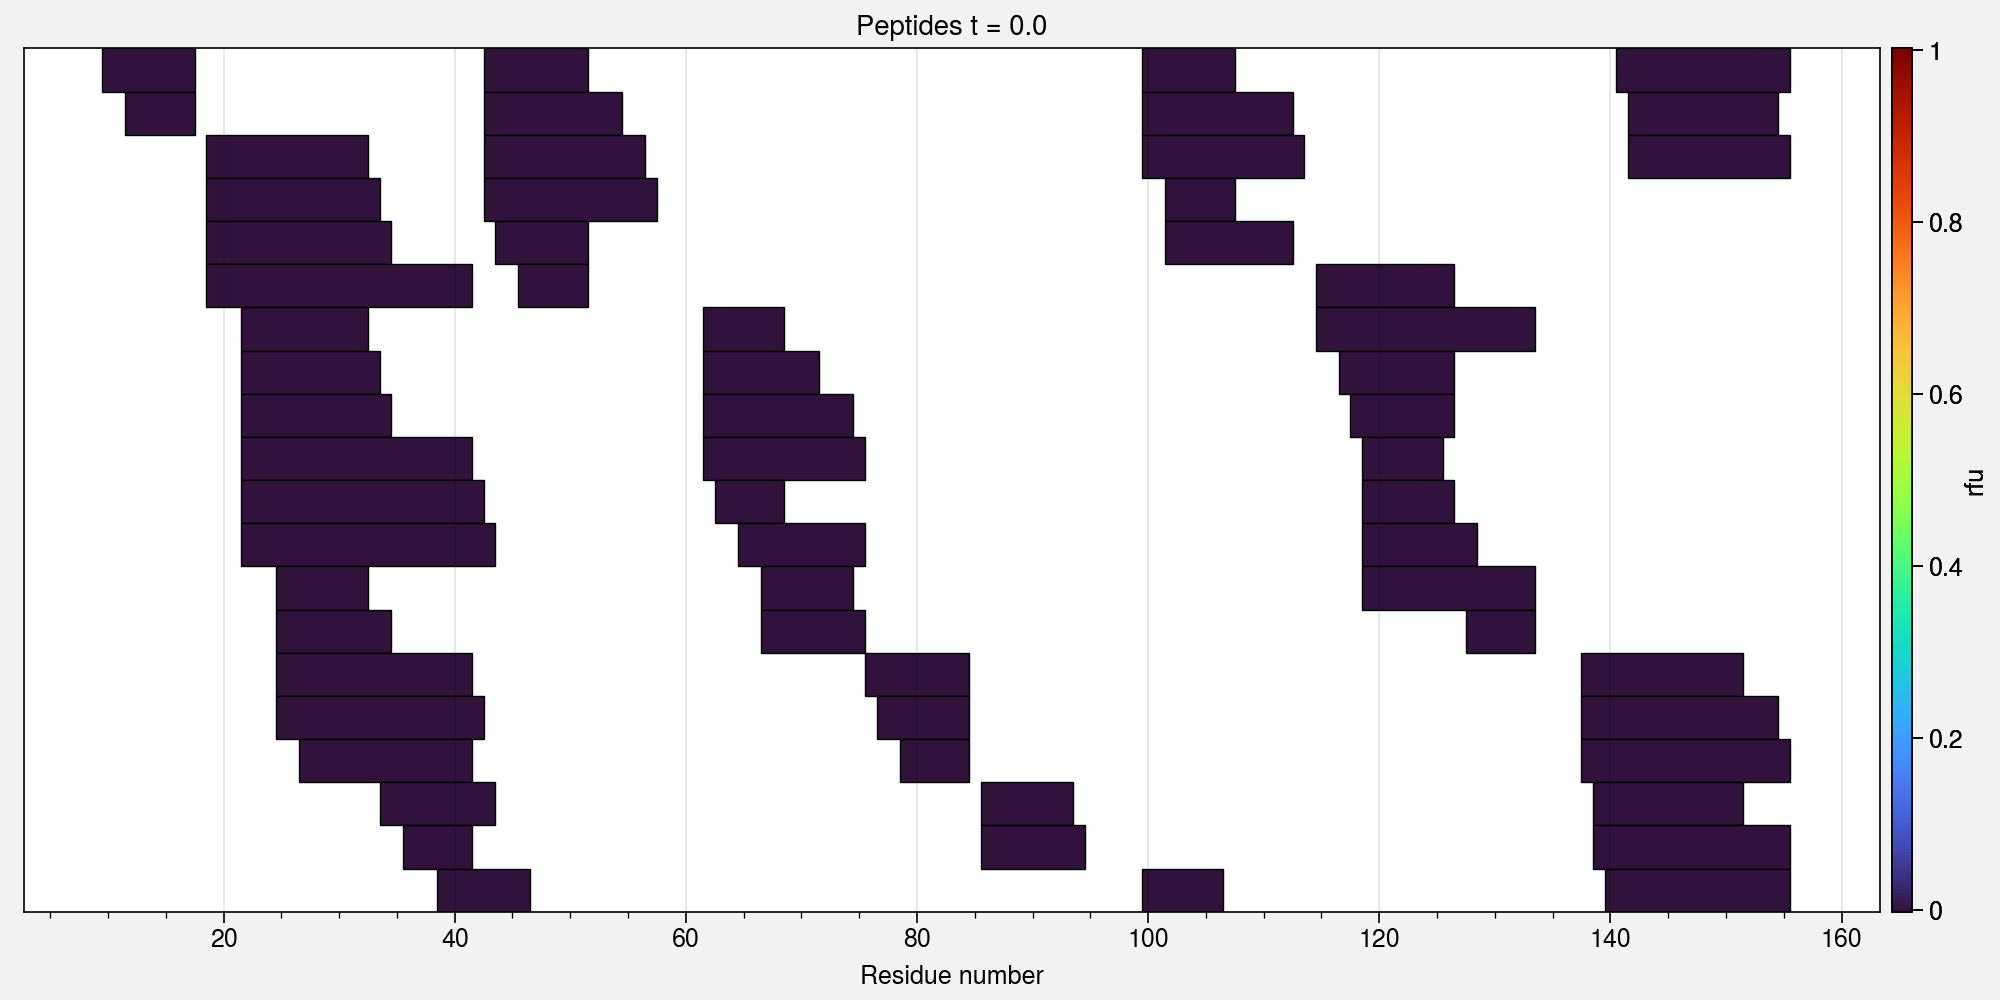

In [17]:
fig, ax = pplt.subplots(figsize=(10, 5))
i = 0
peptide_coverage(ax, hdxm[i].data, 20, cbar=True)
t = ax.set_title(f'Peptides t = {hdxm.timepoints[i]}')
l = ax.set_xlabel('Residue number')

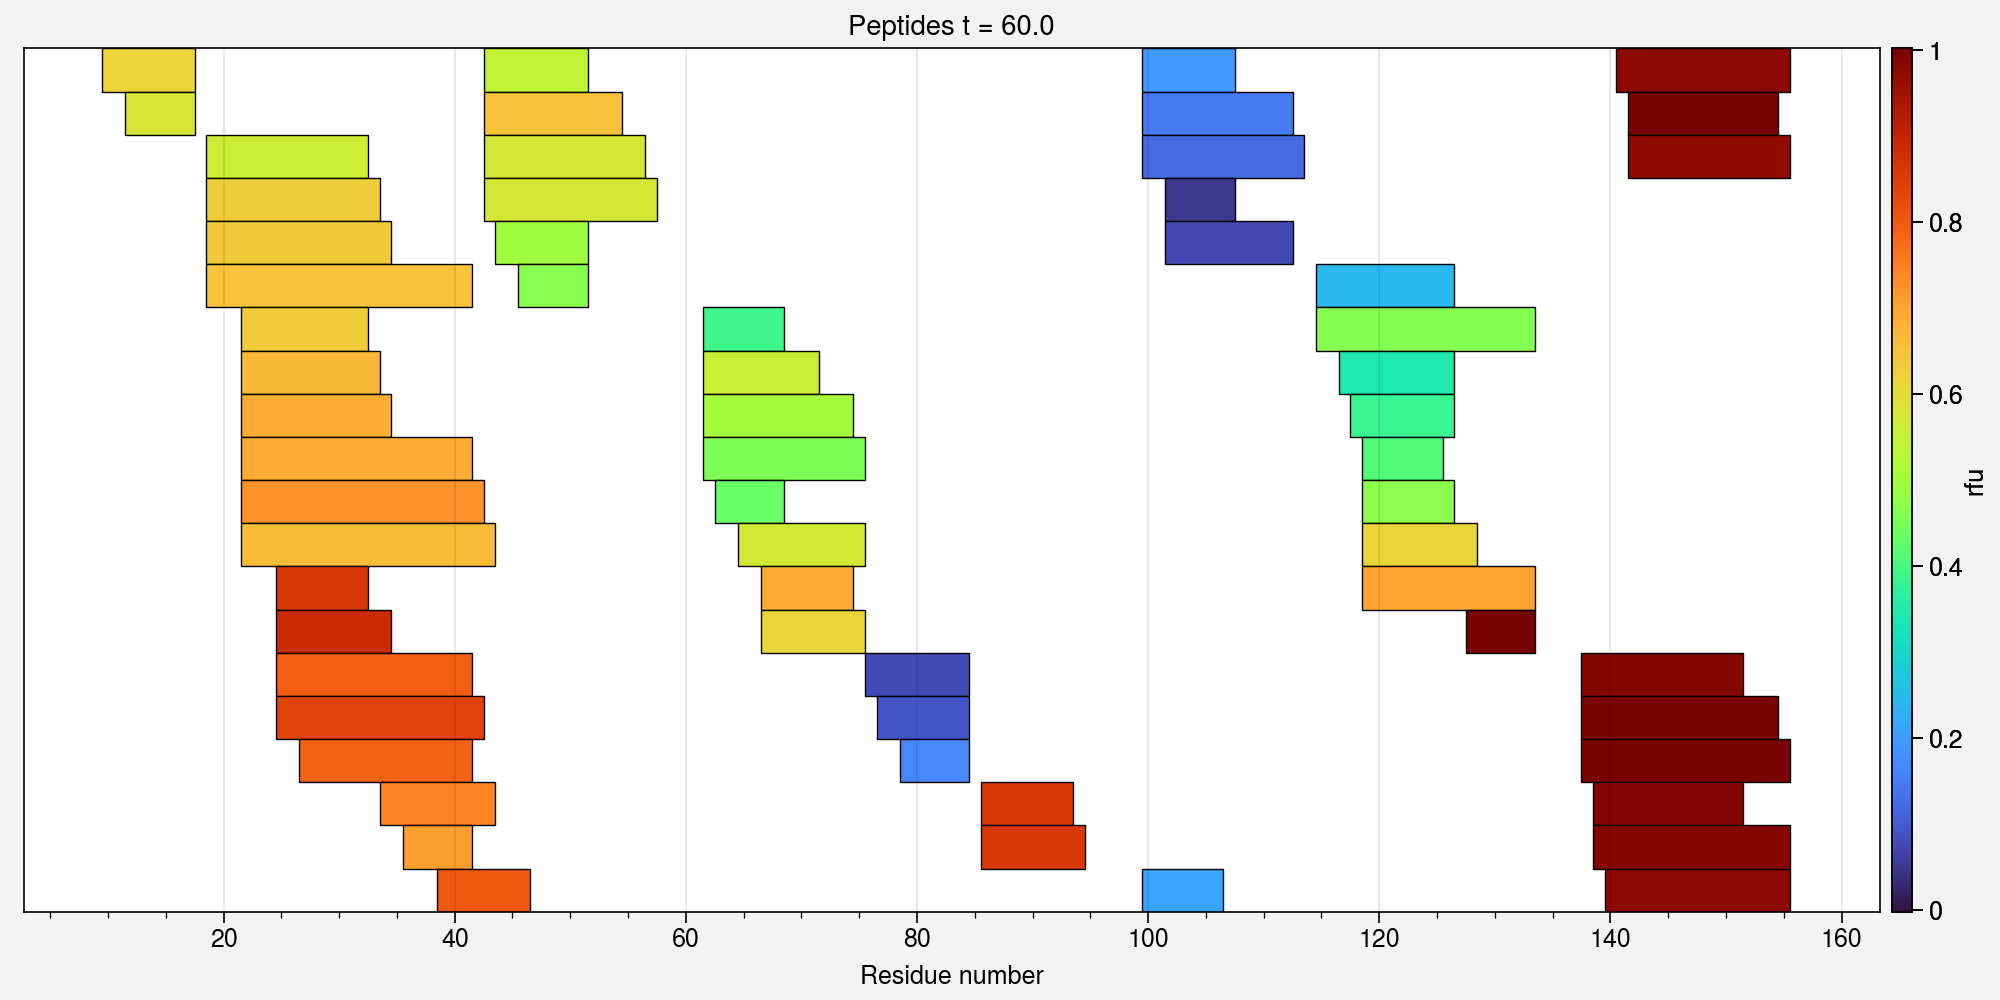

In [18]:
fig, ax = pplt.subplots(figsize=(10, 5))
i = 3
peptide_coverage(ax, hdxm[i].data, 20, cbar=True)
t = ax.set_title(f'Peptides t = {hdxm.timepoints[i]}')
l = ax.set_xlabel('Residue number')

The data in an ``HDXMeasurement`` object can be saved to and reloaded from disk (with associated metadata)
in .csv format.

In [19]:
from pyhdx.fileIO import csv_to_hdxm

hdxm.to_file('My_HDX_file.csv')
hdx_load = csv_to_hdxm('My_HDX_file.csv')
